In [1]:
import os
import keras
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

In [2]:
data_dir = '/kaggle/input/free-spoken-digit-dataset'

### Preprocessing Dataset

In [3]:
import os
import numpy as np
import librosa
from tensorflow.keras.utils import to_categorical

def wav2mfcc(file_path, max_pad_len=20, target_sr=8000, n_fft=512):
    try:
        # Load and resample the audio file
        wave, sr = librosa.load(file_path, mono=True, sr=target_sr)

        # Check if the audio is long enough for the specified n_fft
        if len(wave) < n_fft:
            pad_width = n_fft - len(wave)
            wave = np.pad(wave, (0, pad_width), mode='constant')
            print(f"Padded audio {file_path} with {pad_width} zeros.")
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=20, n_fft=n_fft)

        # Pad or truncate the MFCC features to a fixed length
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def get_data(data_dir, excluded_author='yweweler', max_pad_len=20, target_sr=8000, n_fft=512):
    labels = []
    mfccs = []
    authors = []

    retained_mfccs = []
    retained_labels = []
    excluded_mfccs = []
    excluded_labels = []

    for f in os.listdir(data_dir):
        if f.endswith('.wav'):
            file_path = os.path.join(data_dir, f)
            
            # Extract MFCC features
            mfcc = wav2mfcc(file_path, max_pad_len, target_sr, n_fft)
            if mfcc is not None:
                # Extract label and author from filename
                try:
                    label = int(f.split('_')[0])
                    author = f.split('_')[1]

                    # Append to full dataset
                    mfccs.append(mfcc)
                    labels.append(label)
                    authors.append(author)

                    # Separate into retained and excluded datasets
                    if author == excluded_author:
                        excluded_mfccs.append(mfcc)
                        excluded_labels.append(label)
                    else:
                        retained_mfccs.append(mfcc)
                        retained_labels.append(label)
                except ValueError:
                    print(f"Invalid label in filename: {f}")
                    continue

    # Convert data to numpy arrays
    X = np.asarray(mfccs)
    y = to_categorical(labels)

    X_retained = np.asarray(retained_mfccs)
    y_retained = to_categorical(retained_labels)

    X_excluded = np.asarray(excluded_mfccs)
    y_excluded = to_categorical(excluded_labels)

    return X, y, authors, X_retained, y_retained, X_excluded, y_excluded

In [4]:
X, y, authors_list, X_retained, y_retained, X_excluded, y_excluded = get_data(data_dir)


print(f"X shape: {X.shape}, y shape: {y.shape}, types: {type(X), type(y)}")
print(f"X_excluded shape: {X_excluded.shape}, y_excluded shape: {y_excluded.shape}, types: {type(X_excluded), type(y_excluded)}")
print(f"X_retained shape: {X_retained.shape}, y_retained shape: {y_retained.shape}, types: {type(X_retained), type(y_retained)}")

X shape: (3000, 20, 20), y shape: (3000, 10), types: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
X_excluded shape: (500, 20, 20), y_excluded shape: (500, 10), types: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
X_retained shape: (2500, 20, 20), y_retained shape: (2500, 10), types: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


### Split into Training and Test Sets

In [5]:
# Reshape
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_excluded = X_excluded.reshape(X_excluded.shape[0], X_excluded.shape[1], X_excluded.shape[2], 1)
X_retained = X_retained.reshape(X_retained.shape[0], X_retained.shape[1], X_retained.shape[2], 1)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_excluded shape: {X_excluded.shape}, y_excluded shape: {y_excluded.shape}")
print(f"X_retained shape: {X_retained.shape}, y_retained shape: {y_retained.shape}")

input_shape = (X_retained.shape[1], X_retained.shape[2], 1)
num_classes = y_retained.shape[1]

# Split the retained data into training and testing sets
seed = 95169
X_train_retained, X_test_retained, y_train_retained, y_test_retained = train_test_split(X_retained, y_retained, test_size=0.1, random_state=seed)
X_train_retained_train, X_val_retained, y_train_retained_train, y_val_retained = train_test_split(X_train_retained, y_train_retained, test_size=0.1, random_state=seed)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

X shape: (3000, 20, 20, 1), y shape: (3000, 10)
X_excluded shape: (500, 20, 20, 1), y_excluded shape: (500, 10)
X_retained shape: (2500, 20, 20, 1), y_retained shape: (2500, 10)


In [6]:
X_train = np.vstack((X_train_retained_train, X_excluded))
y_train = np.vstack((y_train_retained_train, y_excluded))
X_test = X_test_retained
y_test = y_test_retained

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_train_retained_train.shape)
print(X_val_retained.shape)
print(y_val_retained.shape)

(2525, 20, 20, 1)
(2525, 10)
(2025, 20, 20, 1)
(225, 20, 20, 1)
(225, 10)


CNN Model

In [8]:
def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(keras.Input((20, 20, 1)))

    model.add(Conv2D(8, kernel_size=(2, 2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.05))
    
    model.add(Conv2D(8, kernel_size=(2, 2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.05))
    
    model.add(Conv2D(16, kernel_size=(2, 2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.05))

    model.add(Conv2D(16, kernel_size=(2, 2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.05))
    
    model.add(Flatten())
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
model = get_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 10, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 10, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 8)        │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 5, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,066 (11.98 KB)

 Trainable params: 2,906 (11.35 KB)

 Non-trainable params: 160 (640.00 B)

In [10]:
# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=1, validation_data=(X_val_retained, y_val_retained))

# Save the initial model after training
model.save('initial_full_dataset_model.h5')

Epoch 1/100


I0000 00:00:1734158291.034548      74 service.cc:145] XLA service 0x7c60f0016690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734158291.034631      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 71/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1180 - loss: 2.7897

I0000 00:00:1734158300.091079      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.1189 - loss: 2.7054 - val_accuracy: 0.1911 - val_loss: 2.2443
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1511 - loss: 2.3863 - val_accuracy: 0.2933 - val_loss: 2.0951
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2162 - loss: 2.2128 - val_accuracy: 0.4489 - val_loss: 1.8372
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2770 - loss: 2.0054 - val_accuracy: 0.5156 - val_loss: 1.6510
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3373 - loss: 1.8647 - val_accuracy: 0.5689 - val_loss: 1.4300
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3743 - loss: 1.7299 - val_accuracy: 0.5956 - val_loss: 1.3241
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4260 - loss: 1.6313 - val_accuracy: 0.6133 - val_loss: 1.2201
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4314 - loss: 1.5838 - val_accuracy: 0.67

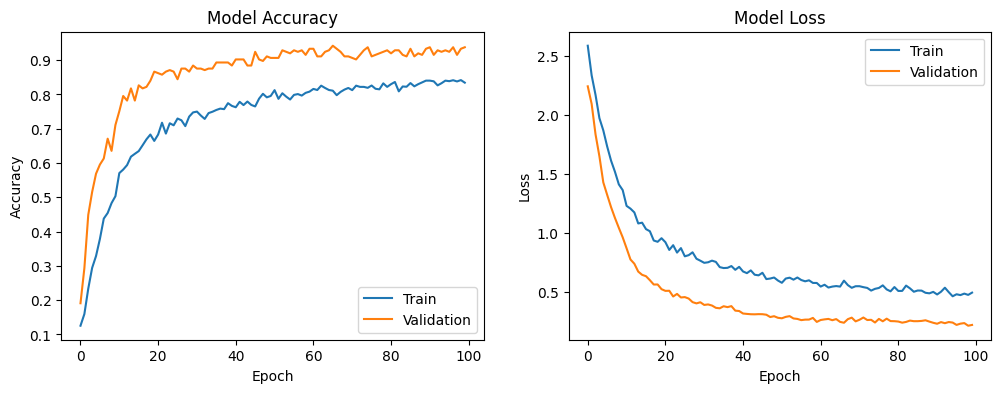

In [11]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Test Model

In [12]:
# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
# print("Test loss:", test_loss)
# print("Test accuracy:", test_accuracy)

# # Save initial model evaluation results for comparison
# with open("initial_model_results.txt", "w") as f:
#     f.write(f"Test loss: {test_loss}\n")
#     f.write(f"Test accuracy: {test_accuracy}\n")

In [13]:
# Make predictions on the test data
def check_performance(x_dataset, y_label, model_to_check, model_name, dataset_name):
    y_dataset_pred = model_to_check.predict(x_dataset)
    y_dataset_pred_int = np.argmax(y_dataset_pred, axis=1)
    
    y_label_int = np.argmax(y_label, axis=1)
    
    assert y_label_int.shape == y_dataset_pred_int.shape
    
    print(f"{model_name} performance on {dataset_name}:")
    print(f1_score(y_label_int, y_dataset_pred_int, average='macro'))
    # print(classification_report(y_label_int, y_dataset_pred_int))

# Train the Golden Standard Model

In [14]:
# Create and compile the gold standard model
gold_standard_model = get_cnn_model(input_shape, num_classes)
gold_standard_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the gold standard model
gold_history = gold_standard_model.fit(
    X_train_retained_train, y_train_retained_train,
    batch_size=16,
    epochs=120,  # Same as fine-tuning epochs for fairness
    validation_data=(X_val_retained, y_val_retained),
    verbose=1
)

# Save the gold standard model
gold_standard_model.save('gold_standard_model.h5')

Epoch 1/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.0867 - loss: 2.8640 - val_accuracy: 0.2044 - val_loss: 2.2294
Epoch 2/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1463 - loss: 2.4103 - val_accuracy: 0.2756 - val_loss: 2.0816
Epoch 3/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1959 - loss: 2.1975 - val_accuracy: 0.3156 - val_loss: 1.8956
Epoch 4/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2787 - loss: 2.0299 - val_accuracy: 0.4044 - val_loss: 1.7036
Epoch 5/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3241 - loss: 1.8582 - val_accuracy: 0.4533 - val_loss: 1.4794
Epoch 6/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3867 - loss: 1.7339 - val_accuracy: 0.5644 - val_loss: 1.2971
Epoch 7/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4259 - loss: 1.6256 - val_accuracy: 0.6178 - val_loss: 1.1662
Epoch 8/120
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4518 - loss: 1.5295 - val_ac

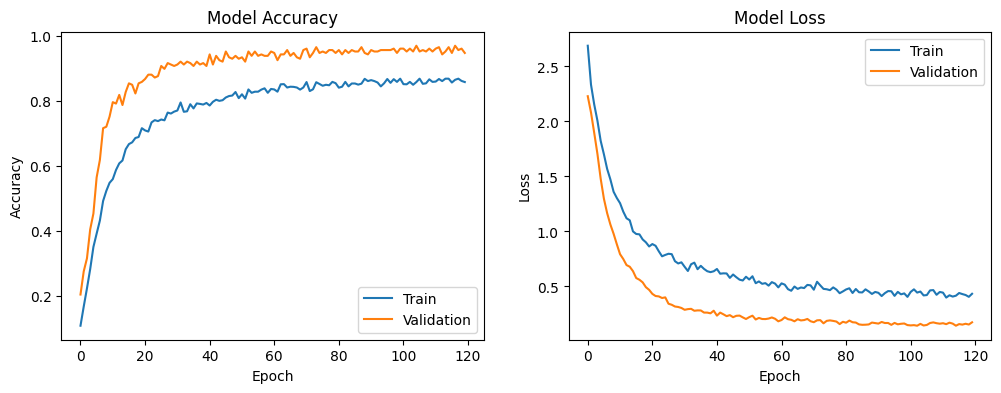

In [16]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(gold_history.history['accuracy'], label='Train')
plt.plot(gold_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(gold_history.history['loss'], label='Train')
plt.plot(gold_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# # Predictions from the gold standard model
# check_performance(X_excluded, y_excluded, gold_standard_model, 'gold standard model', 'excluded set')
# check_performance(X_excluded, y_excluded, model, 'full dataset model', 'excluded set')

# Unlearning

In [18]:
def reset_layer_weights(layer):
  """Resets the weights of a given layer."""
  if hasattr(layer, 'kernel_initializer'):
    layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))
  if hasattr(layer, 'bias_initializer'):
    layer.bias.assign(layer.bias_initializer(layer.bias.shape))


def weight_perturbation(layers, scale):
    max = len(layers) - 1
    layer_to_skip = np.random.randint(low=0, high=max)
    i = 0
    print(layer_to_skip)
    for layer in layers:
        if i == layer_to_skip:
            layer.trainable = False
            continue

        layer.trainable = True
        trainable_weights = layer.trainable_variables

        for weight in trainable_weights:
            random_weights = tf.random.normal(tf.shape(weight), mean=0.0, stddev=1.0, dtype=tf.float32)
            random_weights = random_weights * scale
            weight.assign_add(random_weights)




In [19]:
# step 1
for p in range(3):
    if p == 0:
        reset_all_bn = 0
        reset_conv_bn = 0
    if p == 1:
        reset_all_bn = 1
        reset_conv_bn = 0
    if p == 2:
        reset_all_bn = 0
        reset_conv_bn = 1
    for q in range(3):
        unlearn_model = keras.saving.load_model('/kaggle/working/initial_full_dataset_model.h5')
        # check_performance(X_excluded, y_excluded, unlearn_model, 'full dataset model', 'excluded set')
        reset_layer_weights(unlearn_model.layers[-1])
        reset_layer_weights(unlearn_model.layers[-4])
        
        if reset_all_bn:
            reset_layer_weights(unlearn_model.layers[1])
            reset_layer_weights(unlearn_model.layers[5])
            reset_layer_weights(unlearn_model.layers[9])
            reset_layer_weights(unlearn_model.layers[13])
            reset_layer_weights(unlearn_model.layers[-2])
            print('reset all batchnorm')
        
        if reset_conv_bn:
            reset_layer_weights(unlearn_model.layers[1])
            reset_layer_weights(unlearn_model.layers[5])
            reset_layer_weights(unlearn_model.layers[9])
            reset_layer_weights(unlearn_model.layers[13])
            print('reset convolution batchnorm')
        # check_performance(X_excluded, y_excluded, unlearn_model, 'head-reset full dataset model', 'excluded set')
    
        # check_performance(X_excluded, y_excluded, unlearn_model, 'head-reset full dataset model', 'excluded set')
        new_opt = keras.optimizers.Adam(0.001)
        unlearn_model.compile(optimizer=new_opt, loss='categorical_crossentropy', metrics=['accuracy'])
        unlearn_history_step_1 = unlearn_model.fit(
            X_train_retained_train, y_train_retained_train,
            batch_size=16,
            epochs=5,  # Same as fine-tuning epochs for fairness
            validation_data=(X_val_retained, y_val_retained),
            verbose=0
        )
        unlearn_model.save('finetuned_model_0.h5')
    
        # step 2
        unlearn_model.trainable = True
        unlearn_model.trainable = False
        
        conv_0 = unlearn_model.layers[0]
        conv_1 = unlearn_model.layers[4]
        conv_2 = unlearn_model.layers[8]
        conv_3 = unlearn_model.layers[12]
        fc_0 = unlearn_model.layers[-4]
        fc_1 = unlearn_model.layers[-1]
        
        assert conv_0.trainable == False
        assert conv_1.trainable == False
        assert conv_2.trainable == False
        assert conv_3.trainable == False
        
        unlearn_model.layers[0].trainable = True
        unlearn_model.layers[4].trainable = True
        unlearn_model.layers[8].trainable = True
        unlearn_model.layers[12].trainable = True
        
        assert unlearn_model.layers[0].trainable == True
        assert unlearn_model.layers[4].trainable == True
        assert unlearn_model.layers[8].trainable == True
        assert unlearn_model.layers[12].trainable == True
        
        assert unlearn_model.layers[-1].trainable == False
        assert unlearn_model.layers[-4].trainable == False
        
        conv_layers = [conv_0, conv_1, conv_2, conv_3, fc_0, fc_1]
        
        # check_performance(X, y, unlearn_model, 'post_step_1_unlearned_model', 'full set')
        # check_performance(X_excluded, y_excluded, unlearn_model, 'post_step_1_unlearned_model', 'excluded set')
    
        # train the noise injected layers
        for i in range(5):
        
            weight_perturbation(conv_layers, 0.08)
            # check_performance(X, y, unlearn_model, 'noise_injected_unlearned_model', 'full set')
            # check_performance(X_excluded, y_excluded, unlearn_model, 'noise_injected_unlearned_model', 'excluded set')
            
            unlearn_model.fit(
                X_train_retained_train, y_train_retained_train,
                batch_size=16,
                epochs=1,  # Same as fine-tuning epochs for fairness
                validation_data=(X_val_retained, y_val_retained),
                verbose=0, shuffle=True)
            
            # check_performance(X, y, unlearn_model, 'post_step_2_unlearned_model', 'full set')
            # check_performance(X_excluded, y_excluded, unlearn_model, 'post_step_2_unlearned_model', 'excluded set')
        unlearn_model.save('finetuned_model_1.h5')
    
    
        # step 3 fintune entire model with low l_r
        unlearn_model.trainable = True
        
        assert conv_0.trainable == True
        assert conv_1.trainable == True
        assert conv_2.trainable == True
        assert conv_3.trainable == True
        
        assert unlearn_model.layers[-1].trainable == True
        assert unlearn_model.layers[-4].trainable == True
        
        # fine_opt = keras.optimizers.Adam(0.001)
        # unlearn_model.compile(optimizer=fine_opt, loss='categorical_crossentropy', metrics=['accuracy'])
        unlearn_model.fit(
            X_train_retained_train, y_train_retained_train,
            batch_size=16,
            epochs=5,
            validation_data=(X_val_retained, y_val_retained),
            verbose=0, shuffle=True)
        unlearn_model.save('finetuned_model_3.h5')
        
        # check_performance(X, y, unlearn_model, 'unlearned_model', 'full set')
        # check_performance(X_excluded, y_excluded, unlearn_model, 'unlearned_model', 'excluded set')

        # base model performance
        if q == 0 and p == 0:
            check_performance(X_test_retained, y_test_retained, model, 'base model', 'retained test set')
            check_performance(X_excluded, y_excluded, model, 'base model', 'excluded set')
        
            # gold model performance
            check_performance(X_test_retained, y_test_retained, gold_standard_model, 'gold model', 'retained test set')
            check_performance(X_excluded, y_excluded, gold_standard_model, 'gold model', 'excluded set')
            
        # unlearn model performance
        check_performance(X_test_retained, y_test_retained, unlearn_model, 'unlearn model', 'retained test set')
        check_performance(X_excluded, y_excluded, unlearn_model, 'unlearn model', 'excluded set')
    

4
4
0
1
2
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
base model performance on retained test set:
0.9359640462736438
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
base model performance on excluded set:
0.9681069709460484
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
gold model performance on retained test set:
0.9589339655053941
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
gold model performance on excluded set:
0.6808025618391471
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
unlearn model performance on retained test set:
0.9157386981428497
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
unlearn model performance on excluded set:
0.8302591863186599
2
2
2
4
4
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
unlearn model performance on retained test set:
0.9133345576004231
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
unlearn model performance on excluded set:
0.7317393003860383
4
1
3
1
1
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
unlearn model performance on retained test set:
0.9084527644063588
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
unlearn mo